In [1]:
import numpy as np

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram, plot_gate_map
from qiskit import IBMQ, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer import noise


In [2]:
# Create a CCZ gate from CCX and H
def ccz(circuit, q, controls, target):
    circuit.h(q[target])
    circuit.ccx(q[controls[0]],q[controls[1]],q[target])
    circuit.h(q[target])

# Convert input bit to 111 by dynamically adding X gates
def complement(circuit, q, bit):
    circuit.barrier()
    truth = [bool(int(i)) for i in list(bit[::-1])]
    for count,i in enumerate(truth):
        if(not i):
            circuit.x(count)
    circuit.barrier()

# Create oracle function satisfying f(x)=1 for x=bit and f(x)=0 for all other x
def oracle(circuit, q, bit):
    complement(circuit, q, bit)
    ccz(circuit, q, [2,1],0)
    complement(circuit, q, bit)


In [3]:
# Create composite iterator gate 
bit = '010'

qi = QuantumRegister(3,'q')
iterator = QuantumCircuit(qi,name='iterator')

# Add oracle
oracle(iterator, qi, bit)

# Add grover diffusion operator
iterator.h(qi)
iterator.x(qi)
iterator.barrier()
ccz(iterator,qi,[2,1],0)
iterator.barrier()
iterator.x(qi)
iterator.h(qi)

# Save gate
grover_iterator = iterator.to_instruction()

In [6]:
# Bit being searched for
bit = '010'

mode = "custom" 

# Initialise circuit registers
q = QuantumRegister(3, 'qreg')
c = ClassicalRegister(3, 'creg')
grover = QuantumCircuit(q,c)

grover.h(q);

# Make circuit via appending composite gates (custom) OR functional abstraction (function) method
if(mode=="custom"):
    for i in range(0,2):
        grover.append(grover_iterator, q)
        
elif(mode=="function"):
    
    # add oracle
    oracle(grover,q,bit)
    
    # add grover diffusion operator
    grover.h(q)
    grover.x(q)
    grover.barrier(q)
    ccz(grover, q, [2,1],0)
    grover.barrier(q)
    grover.x(q)
    grover.h(q)

grover.measure(q,c);
    

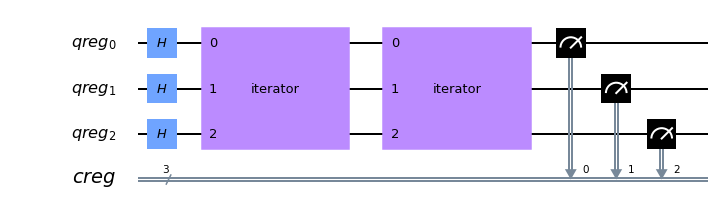

In [7]:
grover.draw(output='mpl')

#provider = IBMQ.load_account()

In [65]:
# run on quantum backend (ibmq_16_melbourne)
back = provider.get_backend('ibmq_16_melbourne')
job = execute(grover,back, shots=1024)
job_monitor(job, interval = 2)

Job Status: job has successfully run


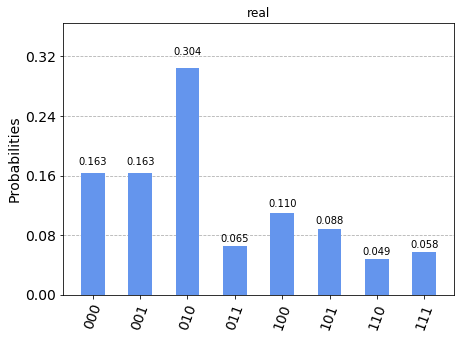

In [93]:
plot_histogram(job.result().get_counts(), title='real', color = 'cornflowerblue')

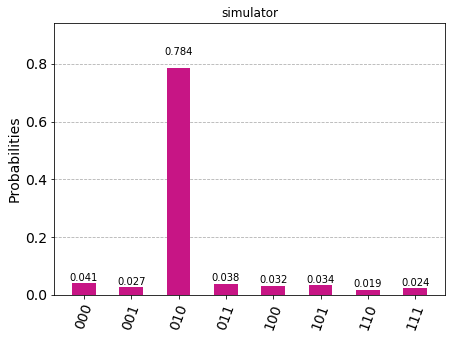

In [102]:
# run on simulator (qasm.simulator)
sim = Aer.get_backend('qasm_simulator')
simJob = execute(grover, sim, shots=1024)
plot_histogram(simJob.result().get_counts(), title="simulator", color='mediumvioletred')

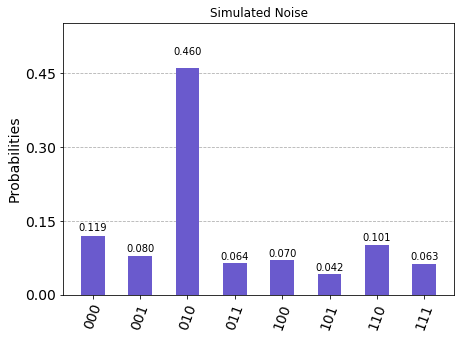

In [103]:
# Store properties of ibmq_16_melbourne 
properties = back.properties()
coupling_map = back.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(properties)

# Emulate backend properties on simulator 
jobNoise = execute(grover,
                   sim,
                   noise_model=noise_model,
                   shots=1024, 
                   coupling_map=coupling_map, 
                   basis_gates=noise_model.basis_gates)
plot_histogram(jobNoise.result().get_counts(), color='slateblue', title='Simulated Noise')

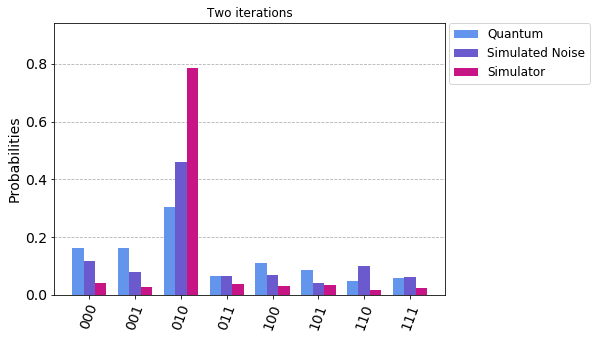

In [104]:
# Plot results obtained from three different backends
plot_histogram([job.result().get_counts(), jobNoise.result().get_counts(), simJob.result().get_counts()],
               legend=['Quantum', 'Simulated Noise', 'Simulator', ],
               bar_labels=False,
               title='Two iterations', 
               color=['cornflowerblue', 'slateblue', 'mediumvioletred'])